In [21]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
import sys
import importlib
from PIL import Image
from IPython.display import display, HTML
import random
sys.path.append('../')

if 'playscript_utils' in sys.modules:
    importlib.reload(sys.modules['playscript_utils'])
else:
    import playscript_utils
from playscript_utils import model_name_dict, emotions, filter_csv_by_columns, chat_template, filter_criteria_to_string


In [22]:
def emotion_classification_accuracy_verify(emotion_metrics_path, emotions, filter_criteria):
    filtered_df = filter_csv_by_columns(emotion_metrics_path, filter_criteria)
    print(f"Length of filtered_df with criteria {filter_criteria}: {len(filtered_df)}")
    emotion_accuracies = {emotion: [0, 0] for emotion in emotions}
    for emotion in emotions:
        for index, row in filtered_df.iterrows():
            alice_emotion = row['alice_emotion']
            bob_emotion = row['bob_emotion']
            emotion_scores = ast.literal_eval(row['emotion_scores'])
            if alice_emotion == emotion:
                for alice_score in emotion_scores[emotion][::2]:
                    emotion_accuracies[emotion][1] += 1
                    if alice_score > 0:
                        emotion_accuracies[emotion][0] += 1
            if bob_emotion == emotion:
                for bob_score in emotion_scores[emotion][1::2]:
                    emotion_accuracies[emotion][1] += 1
                    if bob_score > 0:
                        emotion_accuracies[emotion][0] += 1
    emotion_accuracies["Mean"] = [sum(accuracy[0] for accuracy in emotion_accuracies.values()), sum(accuracy[1] for accuracy in emotion_accuracies.values())]
    for emotion, accuracy in emotion_accuracies.items():
        assert accuracy[1] > 0, f"Denominator for emotion '{emotion}' should be greater than 0"
    
    emotion_accuracies_html = f"""
    <html>
        <body>
            <h4>Emotion Classification Accuracy: {filter_criteria_to_string(filter_criteria, "display")}</h4>
            <table border='1'>
                <tr>
                    <th>Emotion</th>
                    <th>Accuracy</th>
                </tr>
    """
    for emotion, accuracy in emotion_accuracies.items():
        emotion_accuracies_html += f"<tr><td>{emotion}</td><td>{accuracy[0]} / {accuracy[1]} = {accuracy[0] / accuracy[1] * 100:.2f}%</td></tr>"
    emotion_accuracies_html += "</table></body></html>"
    
    return emotion_accuracies_html

In [23]:
def standout_dialogues(emotion_metrics_path, emotions, extract_k, filter_criteria):
    filtered_df = filter_csv_by_columns(emotion_metrics_path, filter_criteria)
    print(f"Length of filtered_df with criteria {filter_criteria}: {len(filtered_df)}")
    all_scores = {emotion: [] for emotion in emotions}
    all_dialogues = []
    for index, row in filtered_df.iterrows():
        # Convert string literal to list of dialogues
        dialogues = ast.literal_eval(row['dialogues'])
        all_dialogues.extend(dialogues)
        # Convert string literal to dictionary {emotion: list of scores, ...}
        emotion_scores = ast.literal_eval(row['emotion_scores'])

        for emotion in emotions:
            all_scores[emotion].extend(emotion_scores[emotion])
    
    emotion_standouts = {emotion: {"top_k": [], "bottom_k": [], "random_k": []} for emotion in emotions}
    for emotion in emotions:
        # Sort the dialogues based on the current emotion                        
        paired = list(zip(all_scores[emotion], all_dialogues))
        sorted_pairs = sorted(paired, key=lambda x: x[0])

        # Get the top and bottom k
        top_k = sorted_pairs[-extract_k:][::-1]
        bottom_k = sorted_pairs[:extract_k]

        emotion_standouts[emotion]["top_k"] = top_k
        emotion_standouts[emotion]["bottom_k"] = bottom_k
        emotion_standouts[emotion]["random_k"] = random.sample(paired, extract_k)

    emotion_standouts_html = f"""
    <html>
        <body>
            <h4>Emotion Standouts for {filter_criteria_to_string(filter_criteria, "display")}</h4>
            <table border="1">
                <tr>
                    <th>Emotion</th>
                                    """
    for k in range(extract_k):
        emotion_standouts_html += f"""
                    <th>Best Score {k+1}</th>
                    <th>Best Dialogue {k+1}</th>
        """
    for k in range(extract_k):
        emotion_standouts_html += f"""
                    <th>Worst Score {k+1}</th>
                    <th>Worst Dialogue {k+1}</th>
        """
    emotion_standouts_html += """
                </tr>
        """

    for emotion, scores in emotion_standouts.items():
        best_scores = [round(score[0], 2) for score in scores['top_k']]
        worst_scores = [round(score[0], 2) for score in scores['bottom_k']]
        best_dialogues = [score[1] for score in scores['top_k']]
        worst_dialogues = [score[1] for score in scores['bottom_k']]
        emotion_standouts_html += f"""
            <tr>
                <td>{emotion}</td>
        """
        for k in range(extract_k):
            emotion_standouts_html += f"""
                <td>{best_scores[k]}</td>
                <td>{best_dialogues[k]}</td>
            """
        for k in range(extract_k):
            emotion_standouts_html += f"""
                <td>{worst_scores[k]}</td>
                <td>{worst_dialogues[k]}</td>
            """
        emotion_standouts_html += """
            </tr>
        """

    emotion_standouts_html += """
        </table>
    </body>
    </html>
    """

    return emotion_standouts_html

In [24]:
def emotion_scores_all_dialogues_histogram(emotion_metrics_path, emotions, filter_criteria, filter_emotions):
    filtered_df = filter_csv_by_columns(emotion_metrics_path, filter_criteria)
    print(f"Length of filtered_df with criteria {filter_criteria}: {len(filtered_df)}")
    fig, axes = plt.subplots(3, 2, figsize=(8, 8))  # Create a 3x2 grid for the plots
    fig.suptitle(f"Histogram of emotion scores of all dialogues: {filter_criteria_to_string(filter_criteria, 'display')}, filter_emotions={filter_emotions}", wrap=True)  # Set the title of the grid
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for idx, emotion in enumerate(emotions):
        alice_scores = []
        bob_scores = []

        for index, row in filtered_df.iterrows():
            # Convert string literal to dictionary of {emotion: list of scores}
            emotion_scores = ast.literal_eval(row['emotion_scores'])
            if filter_emotions:
                if row['alice_emotion'] == emotion:            
                    alice_scores.extend(emotion_scores[emotion][::2])
                if row['bob_emotion'] == emotion:
                    bob_scores.extend(emotion_scores[emotion][1::2])
            else:
                alice_scores.extend(emotion_scores[emotion][::2])
                bob_scores.extend(emotion_scores[emotion][1::2])

        bins = 20  # Adjusted bin size for better distribution capture
        axes[idx].hist(alice_scores, bins=bins, alpha=0.3, color='red', label='Alice')  # Increased transparency
        axes[idx].hist(bob_scores, bins=bins, alpha=0.3, color='blue', label='Bob')  # Increased transparency

        # Calculate mean
        alice_mean = np.mean(alice_scores)
        bob_mean = np.mean(bob_scores)

        # Add mean lines
        axes[idx].axvline(alice_mean, color='red', linestyle='solid', linewidth=1)
        axes[idx].axvline(bob_mean, color='blue', linestyle='solid', linewidth=1)

        # Update legend to include mean values
        axes[idx].legend([f'Alice', f'Bob', f'Alice Mean: {alice_mean:.2f}', f'Bob Mean: {bob_mean:.2f}'], loc='upper right')

        axes[idx].set_title(f'{emotion} Comparison')  # Updated title
        axes[idx].set_xlabel(f'{emotion} score')  # Updated X-axis label
        axes[idx].set_ylabel('Frequency')
        print(f"Number of {emotion} scores: Alice={len(alice_scores)}, Bob={len(bob_scores)}")
    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.close(fig)  # Close the figure to prevent it from displaying
    return fig

In [25]:
def average_emotion_score_over_time_chart(emotion_metrics_path, filter_criteria):
    # Create the line chart
    x_labels = ['A1', 'B1', 'A2', 'B2', 'A3', 'B3']
    alice_colors = {"False": "lightpink", "True": "red"}
    bob_colors = {"False": "lightblue", "True": "blue"}
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(f"Average Emotion Scores Over Time\n{filter_criteria_to_string(filter_criteria, 'display')}", wrap=True)

    # Combine Alice and Bob plots for both dialogue_concatenate=False and True
    for dialogue_concatenate in ['False', 'True']:
        filter_criteria['dialogue_concatenate'] = dialogue_concatenate
        filtered_df = filter_csv_by_columns(emotion_metrics_path, filter_criteria)
        print(f"Length of filtered_df with criteria {filter_criteria}: {len(filtered_df)}")
        alice_scores_all_premises = []
        bob_scores_all_premises = []

        for index, row in filtered_df.iterrows():
            alice_emotion = row['alice_emotion']
            bob_emotion = row['bob_emotion']
            
            # Skip if alice_emotion or bob_emotion is "generic"
            if alice_emotion == "generic" or bob_emotion == "generic":
                continue
            
            # Convert string literal to dictionary of {emotion: list of scores}
            emotion_scores = ast.literal_eval(row['emotion_scores'])
            
            # Create the list of scores for the current premise
            alice_scores = emotion_scores[alice_emotion]
            bob_scores = emotion_scores[bob_emotion]
            alice_scores_all_premises.append(alice_scores)
            bob_scores_all_premises.append(bob_scores)
        
        # Convert to numpy array for easier manipulation
        alice_scores_all_premises = np.array(alice_scores_all_premises)
        bob_scores_all_premises = np.array(bob_scores_all_premises)
        
        # Calculate the average score for each of the 6 positions
        alice_average_scores = np.mean(alice_scores_all_premises, axis=0)
        bob_average_scores = np.mean(bob_scores_all_premises, axis=0)
        
        # Calculate the confidence intervals
        alice_confidence_intervals = 1.96 * np.std(alice_scores_all_premises, axis=0) / np.sqrt(alice_scores_all_premises.shape[0])
        bob_confidence_intervals = 1.96 * np.std(bob_scores_all_premises, axis=0) / np.sqrt(bob_scores_all_premises.shape[0])

        # Plot the data
        ax.errorbar(x_labels, alice_average_scores, yerr=alice_confidence_intervals, fmt='-o', capsize=5, label=f'Alice: dialogue_concatenate={dialogue_concatenate}', color=alice_colors[dialogue_concatenate])
        ax.errorbar(x_labels, bob_average_scores, yerr=bob_confidence_intervals, fmt='-o', capsize=5, label=f'Bob: dialogue_concatenate={dialogue_concatenate}', color=bob_colors[dialogue_concatenate])
    ax.set_xlabel('Conversation Turn')
    ax.set_ylabel('Average Emotion Score')
    ax.set_ylim(-12.5, 12.5)
    ax.legend()   
    plt.tight_layout()
    plt.close()
    return fig

In [26]:
def sweep_emotion_classification_accuracy_verify(emotion_metrics_path, emotions):
    for premise_type in ["neutral"]:
        for probing_model in ["llama2_13b_chat"]:
            for probing_method in ["logistic_regression"]:
                for probing_layer in ["39"]:
                    for probing_dataset in ["playscript_neutral_train"]:
                        for stimulis_format in ["simple"]:
                            for include_character in ["True"]:
                                for dialogue_concatenate in ["False"]:
                                    filter_criteria = {"premise_type": premise_type, "probing_model": probing_model, "probing_method": probing_method, "probing_layer": probing_layer, "probing_dataset": probing_dataset, "stimulis_format": stimulis_format, "include_character": include_character, "dialogue_concatenate": dialogue_concatenate}
                                    filter_criteria_file_name = filter_criteria_to_string(filter_criteria, "file_name")
                                    emotion_accuracies_html = emotion_classification_accuracy_verify(emotion_metrics_path, emotions, filter_criteria)
                                    html_output_path = f"../results/emotion_classification_accuracy_verify/{filter_criteria_file_name}.html"
                                    with open(html_output_path, "w", encoding="utf-8") as html_file:
                                        html_file.write(emotion_accuracies_html)
                                        display(HTML(emotion_accuracies_html))

In [27]:
def sweep_standout_dialogues(emotion_metrics_path, emotions, extract_k):
    for premise_type in ["neutral"]:
        for probing_model in ["llama2_13b_chat"]:
            for probing_method in ["logistic_regression"]:
                for probing_layer in ["39"]:
                    for probing_dataset in ["playscript_neutral_train"]:
                        for stimulis_format in ["simple"]:
                            for include_character in ["True"]:
                                for dialogue_concatenate in ["False"]:
                                    filter_criteria = {"premise_type": premise_type, "probing_model": probing_model, "probing_method": probing_method, "probing_layer": probing_layer, "probing_dataset": probing_dataset, "stimulis_format": stimulis_format, "include_character": include_character, "dialogue_concatenate": dialogue_concatenate}
                                    filter_criteria_file_name = filter_criteria_to_string(filter_criteria, "file_name")
                                    emotion_standouts_html = standout_dialogues(emotion_metrics_path, emotions, extract_k, filter_criteria=filter_criteria)

                                    # Display the HTML file
                                    html_output_path = f"../results/standout_dialogues/{filter_criteria_file_name}.html"
                                    with open(html_output_path, "w", encoding="utf-8") as html_file:
                                        html_file.write(emotion_standouts_html)
                                        display(HTML(emotion_standouts_html))

In [28]:
def sweep_emotion_scores_all_dialogues_histogram(emotion_metrics_path, emotions):
    for premise_type in ["neutral"]:
        for probing_model in ["llama2_13b_chat"]:
            if premise_type == "creative":
                filter_emotions = False
            else:
                filter_emotions = True
            for probing_method in ["logistic_regression"]:
                for probing_layer in ["39"]:
                    for probing_dataset in ["playscript_neutral_train"]:
                        for stimulis_format in ["simple"]:
                            for include_character in ["True"]:
                                for dialogue_concatenate in ["True"]:
                                    filter_criteria = {"premise_type": premise_type, "probing_model": probing_model, "probing_method": probing_method, "probing_layer": probing_layer, "probing_dataset": probing_dataset, "stimulis_format": stimulis_format, "include_character": include_character, "dialogue_concatenate": dialogue_concatenate}
                                    filter_criteria_file_name = filter_criteria_to_string(filter_criteria, "file_name")
                                    fig = emotion_scores_all_dialogues_histogram(emotion_metrics_path, emotions, filter_criteria, filter_emotions)
                                    display(fig)
                                    image_path = f"../results/emotion_scores_all_dialogues/{filter_criteria_file_name}.png"
                                    fig.savefig(image_path)

In [29]:
def sweep_average_emotion_score_over_time(emotion_metrics_path):
    for premise_type in ["neutral"]:
        for probing_model in ["llama2_13b_chat"]:
            for probing_method in ["logistic_regression"]:
                for probing_layer in ["39"]:
                    for probing_dataset in ["playscript_neutral_train"]:
                        for stimulis_format in ["simple"]:
                            for include_character in ["True"]:
                                filter_criteria = {"premise_type": premise_type, "probing_model": probing_model, "probing_method": probing_method, "probing_layer": probing_layer, "probing_dataset": probing_dataset, "stimulis_format": stimulis_format, "include_character": include_character}
                                filter_criteria_file_name = filter_criteria_to_string(filter_criteria, "file_name")
                                fig = average_emotion_score_over_time_chart(emotion_metrics_path, filter_criteria)
                                image_path = f"../results/average_emotion_score_over_time/{filter_criteria_file_name}.png"
                                fig.savefig(image_path)
                                display(fig)

Length of filtered_df with criteria {'premise_type': 'neutral', 'probing_model': 'llama2_13b_chat', 'probing_method': 'logistic_regression', 'probing_layer': '39', 'probing_dataset': 'playscript_neutral_train', 'stimulis_format': 'simple', 'include_character': 'True', 'dialogue_concatenate': 'False'}: 370


Emotion,Accuracy
happiness,350 / 360 = 97.22%
sadness,343 / 360 = 95.28%
anger,345 / 360 = 95.83%
fear,347 / 360 = 96.39%
disgust,339 / 360 = 94.17%
surprise,322 / 360 = 89.44%
Mean,2046 / 2160 = 94.72%


Length of filtered_df with criteria {'premise_type': 'neutral', 'probing_model': 'llama2_13b_chat', 'probing_method': 'logistic_regression', 'probing_layer': '39', 'probing_dataset': 'playscript_neutral_train', 'stimulis_format': 'simple', 'include_character': 'True', 'dialogue_concatenate': 'False'}: 370


Emotion,Best Score 1,Best Dialogue 1,Best Score 2,Best Dialogue 2,Worst Score 1,Worst Dialogue 1,Worst Score 2,Worst Dialogue 2
happiness,24.04,I’m just thrilled to be part of such a lively community that values our history and traditions!,22.91,"Because it’s going to be so much fun! Plus, the kids will love it, and it builds their interest in history!",-27.27,"Oh no, now I'm paranoid! I can't help but think, what if it’s something really dangerous?",-26.36,I can’t shake this feeling like something bad is about to happen here. What if we see something we wish we hadn’t?
sadness,21.48,"Yeah, music can be a bittersweet reminder of what once was.",20.59,"I used to find joy in my photography, but lately, it just feels like a reminder of everything that's missing.",-29.34,"Seriously, Bob? Ghosts in your art supplies? That’s just ridiculous!",-27.87,"Excited? Bob, we found expired cans in the donation box! How is that not gross?"
anger,25.97,"You act like I’m the only one to blame here! You’ve stopped trying, and it’s infuriating!",22.94,Easier? You’ve completely disregarded my ideas and caused a mess! Do you even care about the community?,-21.16,Definitely! I’ve heard great things about them. It's going to be a fantastic opportunity to learn and connect with others.,-20.19,"Thanks, Alice. It’s just hard to share when things feel so hopeless."
fear,27.02,"I don't know, Bob. What if I pick up something that's cursed? I've heard stories about haunted crafts at fairs like this.",26.39,What if something happens at one of these events? I keep imagining the worst-case scenarios.,-26.7,"I can't believe people actually think these tacky trinkets are worth buying. Ugh, look at that gaudy jewelry!",-26.39,I can't believe they used glitter on that craft! It's so tacky and overdone.
disgust,21.18,I can't even believe people eat from here; it looks so unsanitary.,21.13,"Honestly, I'd rather eat dirt than another round of that nasty food! It's appalling!",-27.67,"I guess, but the pressure is making me anxious… what if I let the team down?",-26.27,Let's celebrate the small wins along the way! That always helps me stay positive.
surprise,23.72,That’s so surprising! I thought this market was thriving.,22.54,Really? I’m shocked that so many people want to get involved!,-23.81,I just have this awful feeling that we might fail… what if we don’t meet our goals?,-23.77,Activities? More like a waste of time! No one ever shows up anyway!


Length of filtered_df with criteria {'premise_type': 'neutral', 'probing_model': 'llama2_13b_chat', 'probing_method': 'logistic_regression', 'probing_layer': '39', 'probing_dataset': 'playscript_neutral_train', 'stimulis_format': 'simple', 'include_character': 'True', 'dialogue_concatenate': 'True'}: 370
Number of happiness scores: Alice=180, Bob=180
Number of sadness scores: Alice=180, Bob=180
Number of anger scores: Alice=180, Bob=180
Number of fear scores: Alice=180, Bob=180
Number of disgust scores: Alice=180, Bob=180
Number of surprise scores: Alice=180, Bob=180


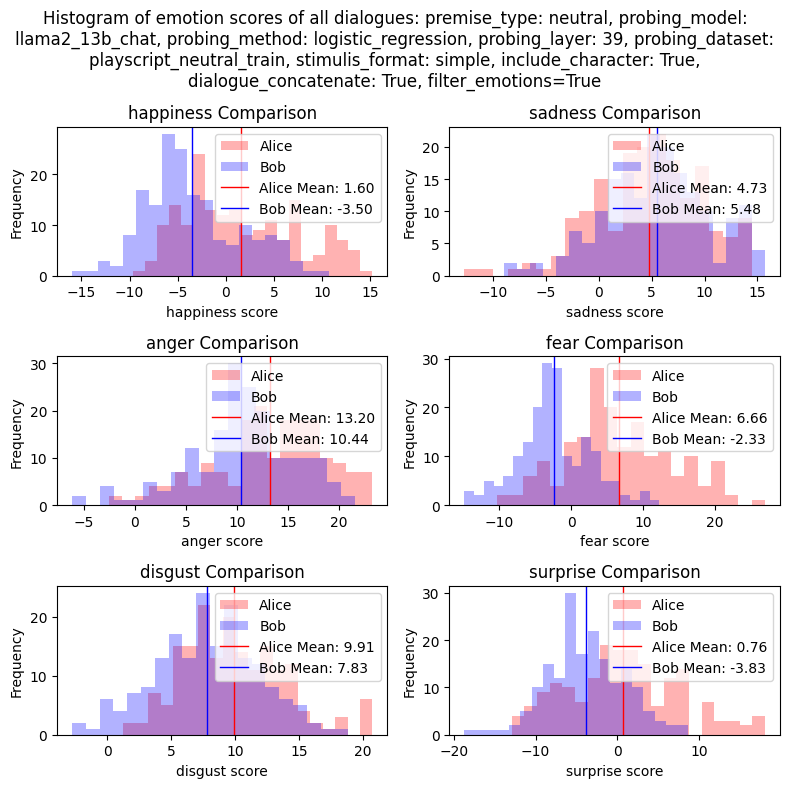

Length of filtered_df with criteria {'premise_type': 'neutral', 'probing_model': 'llama2_13b_chat', 'probing_method': 'logistic_regression', 'probing_layer': '39', 'probing_dataset': 'playscript_neutral_train', 'stimulis_format': 'simple', 'include_character': 'True', 'dialogue_concatenate': 'False'}: 370
Length of filtered_df with criteria {'premise_type': 'neutral', 'probing_model': 'llama2_13b_chat', 'probing_method': 'logistic_regression', 'probing_layer': '39', 'probing_dataset': 'playscript_neutral_train', 'stimulis_format': 'simple', 'include_character': 'True', 'dialogue_concatenate': 'True'}: 370


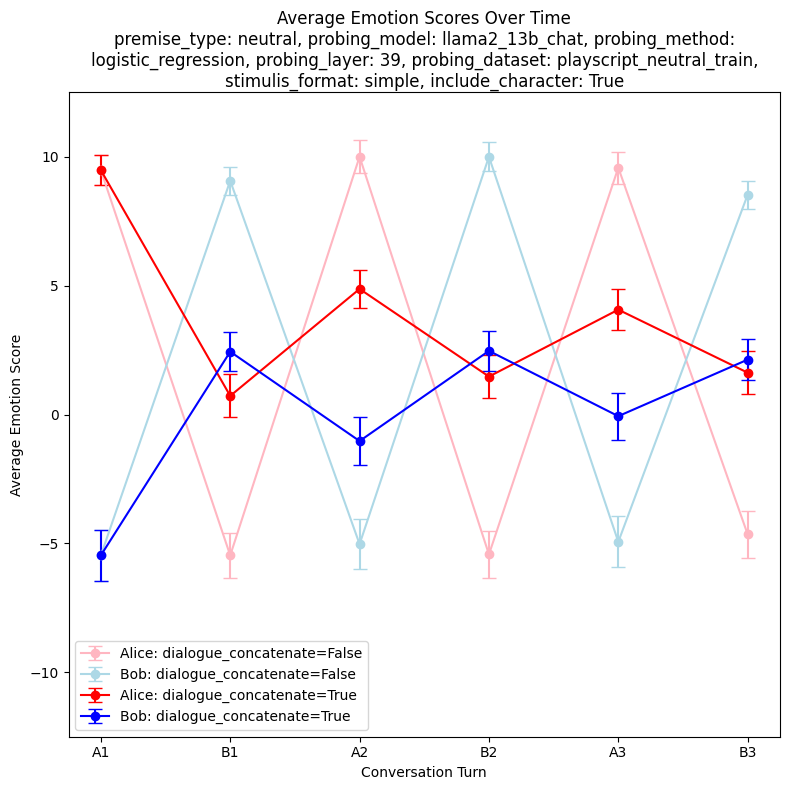

In [30]:
emotion_metrics_path = "../data/permanent/emotion_metrics.csv"
sweep_emotion_classification_accuracy_verify(emotion_metrics_path, emotions)
sweep_standout_dialogues(emotion_metrics_path, emotions, extract_k=2)
sweep_emotion_scores_all_dialogues_histogram(emotion_metrics_path, emotions)
sweep_average_emotion_score_over_time(emotion_metrics_path)